In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.dataset import HumanDataset
import albumentations as A

from lib import *
from time import time
from tqdm.notebook import tqdm

from models.unet import Unet
from models.deeplabv3plus import DeepLabV3plus

from collections import defaultdict
from IPython.display import clear_output

sns.set(font_scale=1.3)

In [2]:
train_image_path = './data/train'
train_mask_path = './data/train_mask'

val_image_path = './data/valid'
val_mask_path = './data/valid_mask'

test_path = './data/test'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def plot_history(history, num_epochs):
    plt.figure(figsize=(16, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(num_epochs) + 1, history['train_loss'], label='train loss')
    plt.plot(np.arange(num_epochs) + 1, history['val_loss'], label='validation loss')
    plt.xlabel('num epochs')
    plt.ylabel('loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(num_epochs) + 1, history['train_acc'], label='train dice')
    plt.plot(np.arange(num_epochs) + 1, history['val_acc'], label='validation dice')
    plt.xlabel('num epochs')
    plt.ylabel('dice')
    plt.legend()
    plt.show()
    

def rename(path, epoch):
    file_name, extension = path.split('/')[-1].split('.')
    path = path.split('/')[:-1]
    path = '/'.join(path) + '/' + file_name + '_{}_epochs'.format(epoch) + '.' + extension
    return path

    
def train(
    model, 
    criterion, 
    optimizer, 
    train_data, 
    val_data, 
    num_epochs, 
    model_path_to_save, 
    history_path_to_save, 
    continue_training=False,
    history=None
):
    if continue_training:
        best_score = history['val_acc'][-1]
    else:
        history = defaultdict(list)
        best_score = 0
    
    elapsed_epochs = len(history['val_acc'])
    for epoch in range(elapsed_epochs, num_epochs + elapsed_epochs):
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        
        start_time = time()
        model.train(True)
        for image_batch, mask_batch in tqdm(train_data):
            image_batch = image_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            predicted_mask = model(image_batch)
            loss = criterion(predicted_mask, mask_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.cpu().item()
            
            predicted_mask = (predicted_mask >= 0) * 1
            mask_batch = mask_batch.squeeze(1).detach().cpu().numpy()
            predicted_mask = predicted_mask.squeeze(1).detach().cpu().numpy()
            
            train_acc += get_dice(mask_batch, predicted_mask)
            
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        with torch.no_grad():
            model.train(False)
            for image_batch, mask_batch in tqdm(val_data):
                image_batch = image_batch.to(device)
                mask_batch = mask_batch.to(device)

                predicted_mask = model(image_batch)
                loss = criterion(predicted_mask, mask_batch)

                val_loss += loss.cpu().item()
                
                predicted_mask = (predicted_mask >= 0) * 1
                mask_batch = mask_batch.squeeze(1).detach().cpu().numpy()
                predicted_mask = predicted_mask.squeeze(1).detach().cpu().numpy()

                val_acc += get_dice(mask_batch, predicted_mask)

            val_loss /= len(val_data)
            val_acc /= len(val_data)

            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            if best_score < val_acc:
                torch.save(model.state_dict(), model_path_to_save)
                pd.DataFrame(history).to_csv(history_path_to_save, index=False)
                best_score = val_acc
                
        clear_output()
        plot_history(history, epoch + 1)
        print('epoch number: {}'.format(epoch + 1))
        print('time per epoch: {}s'.format(np.round(time() - start_time, 3)))
        print('validation acc: {}'.format(np.round(history['val_acc'][-1], 3) * 100))
        print('validation loss: {}'.format(np.round(history['val_loss'][-1], 3)))
    return model, history

# Обучение без аугментации

## Unet

In [19]:
batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

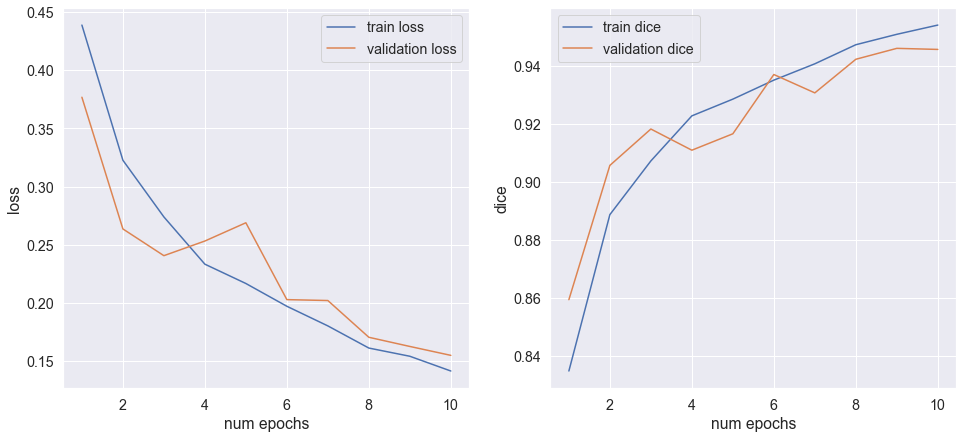

epoch number: 10
time per epoch: 205.236s
validation acc: 94.6
validation loss: 0.155


In [20]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=10, model_path_to_save='./saved_models/unet_no_aug.pth',
    history_path_to_save='./history/unet_no_aug.csv',
)

## DeepLabV3Plus + resnet-101

In [11]:
batch_size = 2

train_dataset = HumanDataset(train_image_path, train_mask_path)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

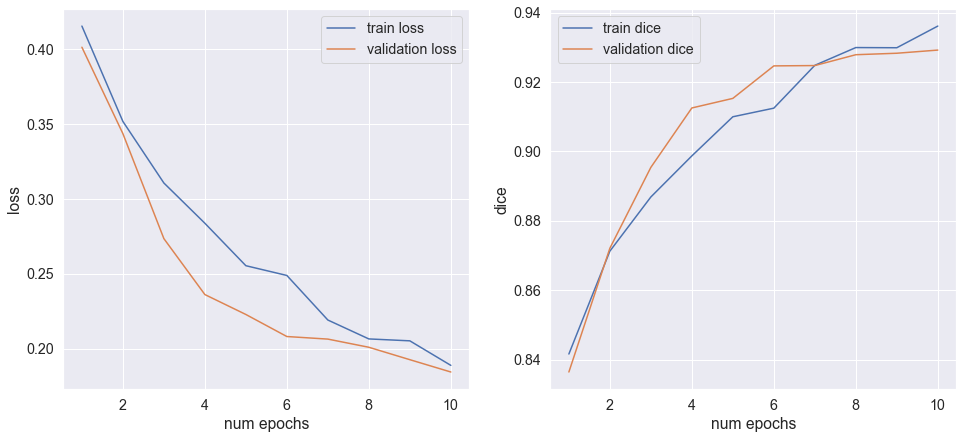

epoch number: 10
time per epoch: 351.486s
validation acc: 92.9
validation loss: 0.184


In [12]:
model = DeepLabV3plus('resnet101').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=10, model_path_to_save='./saved_models/deeplab_resnet101_no_aug.pth',
    history_path_to_save='./history/deeplab_resnet101_no_aug.csv',
)

## DeepLabV3Plus + xception

In [14]:
batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

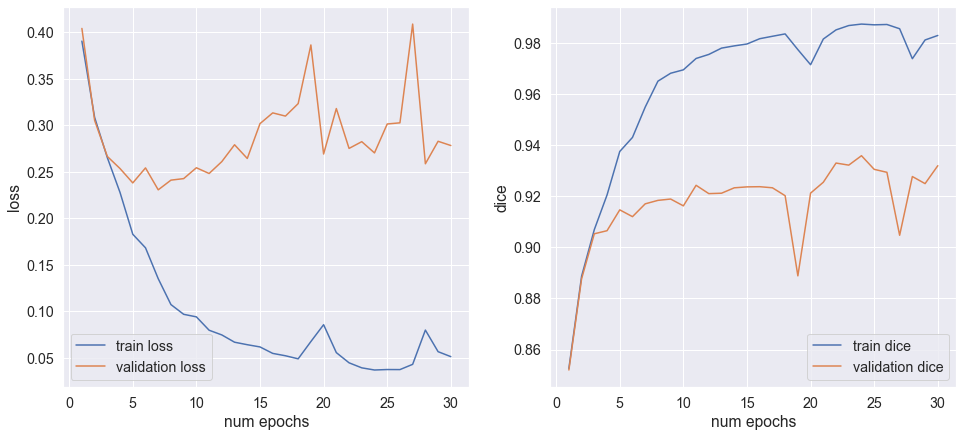

epoch number: 30
time per epoch: 120.424s
validation acc: 93.2
validation loss: 0.278


In [12]:
model = DeepLabV3plus('xception').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=30, model_path_to_save='./saved_models/deeplab_no_aug.pth',
    history_path_to_save='./history/deeplab_no_aug.csv',
)

# Обучение на аугментированных данных (везде Unet)

## Афинное преобразование

In [21]:
augmentations = A.Compose([
    A.augmentations.geometric.transforms.Affine(p=0.5)
])

batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path, augmentations)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

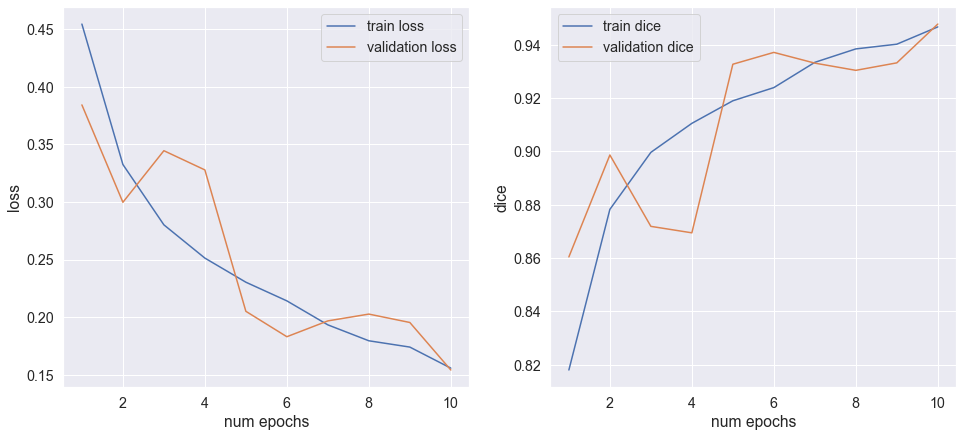

epoch number: 10
time per epoch: 207.327s
validation acc: 94.8
validation loss: 0.154


In [22]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=10, model_path_to_save='./saved_models/unet_affine_aug.pth',
    history_path_to_save='./history/unet_affine_aug.csv',
)

## Нормализация

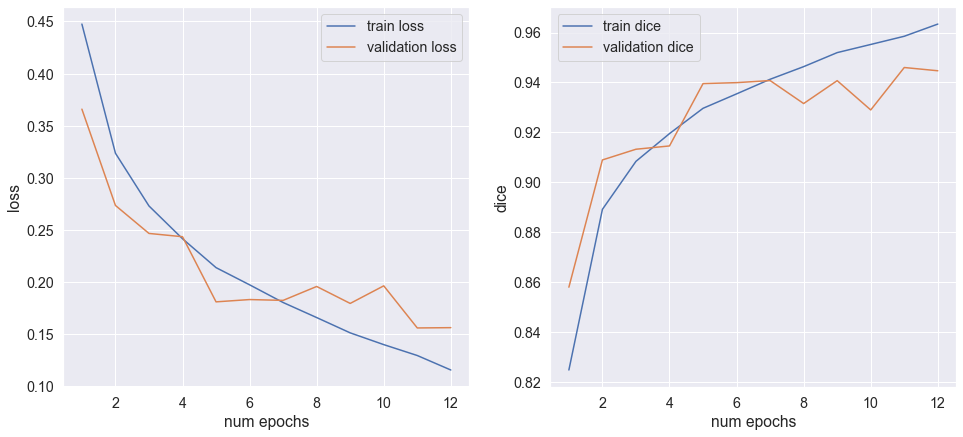

epoch number: 12
time per epoch: 216.301s
validation acc: 94.5
validation loss: 0.156


In [29]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=12, model_path_to_save='./saved_models/unet_norm_aug.pth',
    history_path_to_save='./history/unet_norm_aug.csv',
)

## Изменение яркости

In [30]:
augmentations = A.Compose([
    A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0, always_apply=False, p=0.5)
])

batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path, augmentations)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

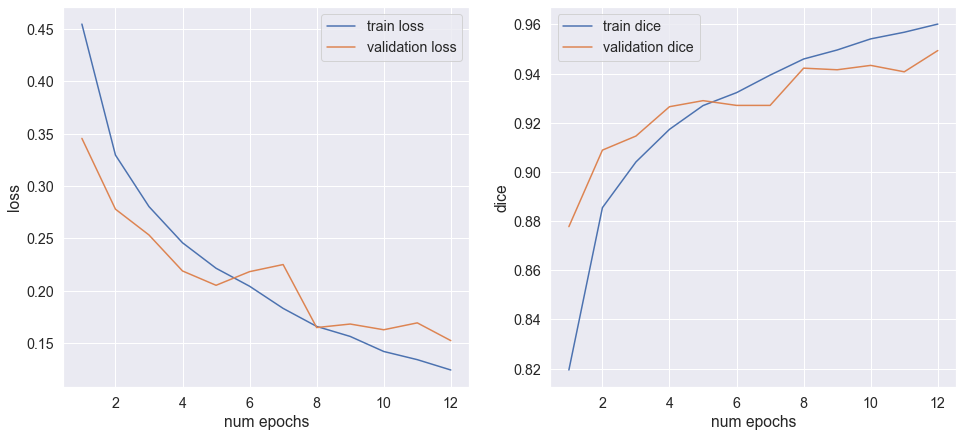

epoch number: 12
time per epoch: 206.324s
validation acc: 94.89999999999999
validation loss: 0.152


In [31]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=12, model_path_to_save='./saved_models/unet_brightness_aug.pth',
    history_path_to_save='./history/unet_brightness_aug.csv',
)

## Изменение контраста

In [32]:
augmentations = A.Compose([
    A.augmentations.transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0, hue=0, always_apply=False, p=0.5)
])

batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path, augmentations)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

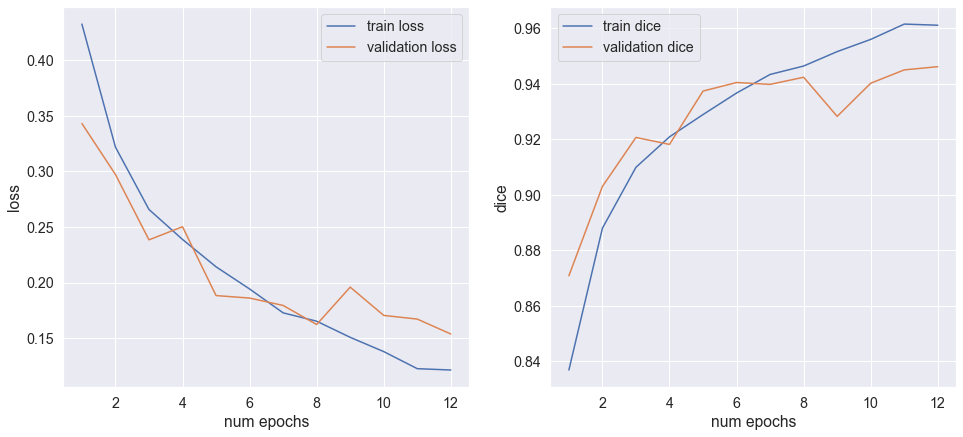

epoch number: 12
time per epoch: 224.093s
validation acc: 94.6
validation loss: 0.154


In [33]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=12, model_path_to_save='./saved_models/unet_contrast_aug.pth',
    history_path_to_save='./history/unet_contrast_aug.csv',
)

## Изменение насыщенности

In [34]:
augmentations = A.Compose([
    A.augmentations.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0, always_apply=False, p=0.5)
])

batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path, augmentations)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

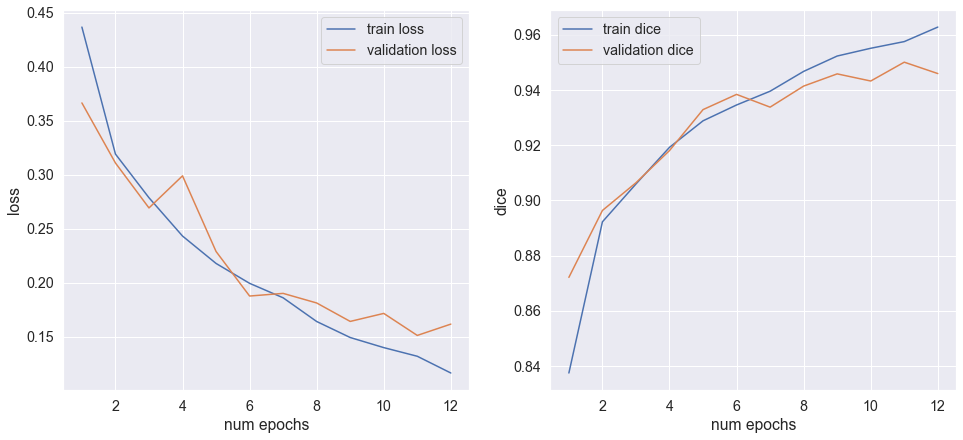

epoch number: 12
time per epoch: 224.358s
validation acc: 94.6
validation loss: 0.162


In [35]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=12, model_path_to_save='./saved_models/unet_saturation_aug.pth',
    history_path_to_save='./history/unet_saturation_aug.csv',
)

# Итоговая модель

In [5]:
augmentations = A.Compose([
    A.augmentations.geometric.transforms.Affine(p=0.5),
    A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0.2, hue=0, always_apply=False, p=0.5),
    A.augmentations.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0, always_apply=False, p=0.5)
])

batch_size = 4

train_dataset = HumanDataset(train_image_path, train_mask_path, augmentations)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

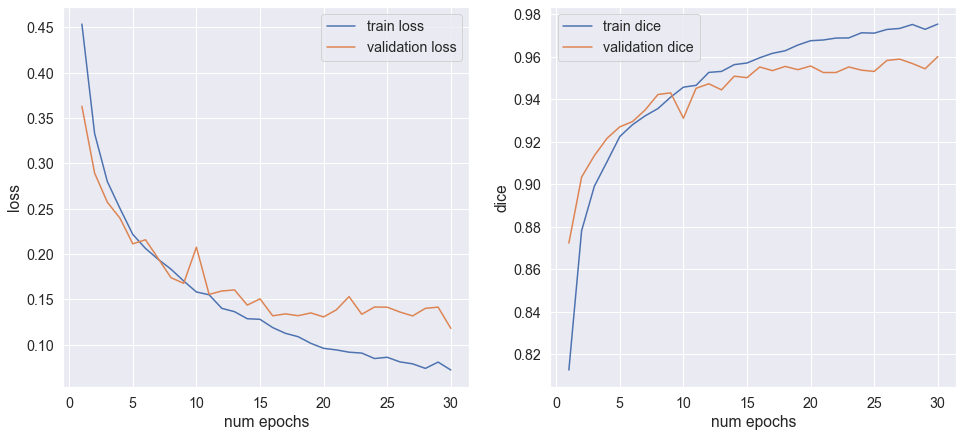

epoch number: 30
time per epoch: 208.379s
validation acc: 96.0
validation loss: 0.118


In [6]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    unet, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=30, model_path_to_save='./saved_models/unet_finall.pth',
    history_path_to_save='./history/unet_finall.csv',
)

# Обучение модели из библиотеки segmentation_models_pytorch

In [5]:
from segmentation_models_pytorch import DeepLabV3Plus

In [6]:
augmentations = A.Compose([
    A.augmentations.geometric.transforms.Affine(p=0.5),
    A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0.2, hue=0, always_apply=False, p=0.5),
    A.augmentations.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0, always_apply=False, p=0.5)
])

batch_size = 8

train_dataset = HumanDataset(train_image_path, train_mask_path, augmentations)
val_dataset = HumanDataset(val_image_path, val_mask_path)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

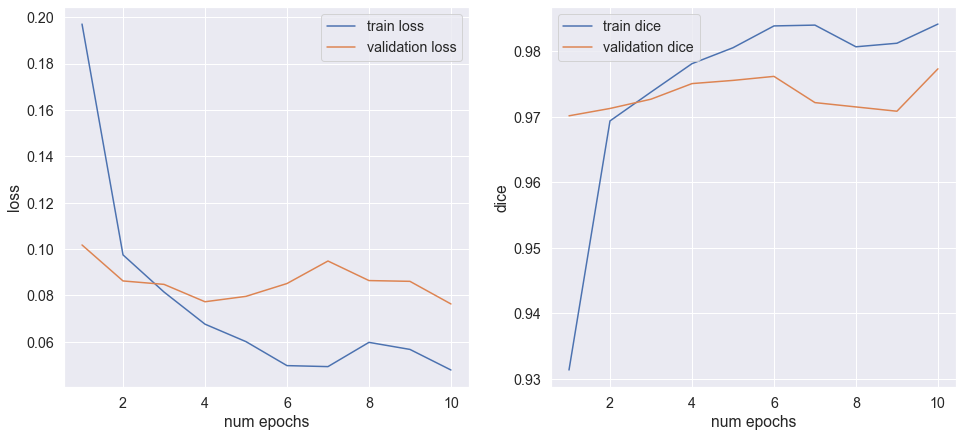

epoch number: 10
time per epoch: 94.787s
validation acc: 97.7
validation loss: 0.076


In [10]:
model = DeepLabV3Plus('resnet101').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader,
    num_epochs=10, model_path_to_save='./saved_models/smp_deeplab_pytorch.pth',
    history_path_to_save='./history/smp_deeplab_pytorch.csv',
)